In [65]:
# 라이브러리 import

import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

In [66]:
# Plot을 위한 준비 

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  
  plt.legend([metric, 'val_'+metric])

In [67]:
# imdb_revies dataset : 영화 리뷰 데이터셋(0:부정적, 1:긍정적 binary labeled)

dataset, info = tfds.load('imdb_reviews', with_info = True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [68]:
# dataset 내용 샘플 확인

for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [69]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [70]:
# data shuffle

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [71]:
# shuffle 이 잘 되었는지 확인

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Unless somebody enlightens me, I really have no idea what this movie is about. It looks like a picture with a message but it\xc2\xb4s far from it. This movie tells pointless story of a New York press agent and about his problems. And, that\xc2\xb4s basically all. When that agent is played by Pacino, one must think that it must be something important. But it takes no hard thinking to figure out how meaningless and dull this movie is. To one of the best actors in the world, Al Pacino, this is the second movie of the year (the other is "Simone") that deserves the title "the most boring and the most pointless motion picture of the year". So, what\xc2\xb4s going on, Al?'
 b"A meteor crashes into Crater Lake, the heat from the impact causing a prehistoric egg to hatch.<br /><br />Alright, so the plot is just trash. But despite its obvious low budget, this comes across as one of the most gripping and entertaining monster-on-the-loose films in existence. There are also some good mom

In [72]:
# dataset 토큰화 -> 단어 단위로 토큰 추출
# 추출한 토큰으로 단어 목록 세팅

VOCAB_SIZE = 1000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
tokenizer.adapt(train_dataset.map(lambda text, label: text))

In [73]:
# 빈도순으로 단어 출력 확인

vocab = np.array(tokenizer.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [74]:
# 문장의 각 단어를 vacab에서 위치하는 index로 치환 

tokenized_example = tokenizer(example)[:3].numpy()
tokenized_example

array([[893,   1,   1, ...,   0,   0,   0],
       [  4,   1,   1, ...,   0,   0,   0],
       [ 34, 165,   1, ...,   0,   0,   0]])

In [75]:
# Tokenize 과정에서 대소문자, 특수문자 등을 처리하기 때문에
# 원문 -> tokenized -> 원문으로 되돌릴 경우 완벽하지 않고 unknown token이 생길 수 있음 

for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[tokenized_example[n]]))
  print()

Original:  b'Unless somebody enlightens me, I really have no idea what this movie is about. It looks like a picture with a message but it\xc2\xb4s far from it. This movie tells pointless story of a New York press agent and about his problems. And, that\xc2\xb4s basically all. When that agent is played by Pacino, one must think that it must be something important. But it takes no hard thinking to figure out how meaningless and dull this movie is. To one of the best actors in the world, Al Pacino, this is the second movie of the year (the other is "Simone") that deserves the title "the most boring and the most pointless motion picture of the year". So, what\xc2\xb4s going on, Al?'
Round-trip:  unless [UNK] [UNK] me i really have no idea what this movie is about it looks like a picture with a message but [UNK] far from it this movie tells [UNK] story of a new york [UNK] [UNK] and about his problems and [UNK] basically all when that [UNK] is played by [UNK] one must think that it must be s

모델 구조
---
 input  ▶ 자연어 문장

 TextVectorization  ▶ 각각의 단어를 정수로 변환

 Embedding ▶ 들어온 정수를 가중치 벡터 로 변환

 LSTM ▶ 각 단어에 대해 독립적으로 구한 값을 모두 연관지어 최종 이 문장의 가중치 계산

 Dense ▶ 하나의 결과값(부정~긍정)을 갇도록 함





In [76]:


model = tf.keras.Sequential([
    tokenizer,
    tf.keras.layers.Embedding(
        input_dim=len(tokenizer.get_vocabulary()),
        output_dim=64,                                          # 각각의 단어를 크기가 64인 vector로 변환
        mask_zero=True),                                        # 64개의 조건에 따른 가중치 값을 가짐
    tf.keras.layers.LSTM(64),                                   # Unidirectional (수정)
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),   # Bidirectional (기존)
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [77]:
# Tokenizer 레이어 외에는 모두 마스킹 기능을 사용하고 있음
# 패딩된 부분은 제외하고 순수 문장만 가지고 실행함

print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [78]:
# sample text를 예측했을 때 나온 결과값

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.01694372]


In [79]:
# 위와 같은 문장 뒤쪽의 빈 공간을 the 로 패딩하여 채우고 예측했을 때 나온 결과값 
# 결과가 같은 것을 확인할 수 있음 -> 뒤쪽에 패딩된 내용은 결과에 영향을 주지 않음

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.01694373]


In [80]:
# 모델 생성

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [81]:
# 모델 학습

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 22s 47ms/step - loss: 0.6262 - accuracy: 0.5793 - val_loss: 0.4965 - val_accuracy: 0.7786
Epoch 2/10
391/391 [==============================] - 18s 44ms/step - loss: 0.4056 - accuracy: 0.8206 - val_loss: 0.3837 - val_accuracy: 0.8365
Epoch 3/10
391/391 [==============================] - 18s 44ms/step - loss: 0.3412 - accuracy: 0.8560 - val_loss: 0.3484 - val_accuracy: 0.8531
Epoch 4/10
391/391 [==============================] - 18s 44ms/step - loss: 0.3245 - accuracy: 0.8628 - val_loss: 0.3439 - val_accuracy: 0.8505
Epoch 5/10
391/391 [==============================] - 18s 44ms/step - loss: 0.3160 - accuracy: 0.8680 - val_loss: 0.3337 - val_accuracy: 0.8505
Epoch 6/10
391/391 [==============================] - 18s 44ms/step - loss: 0.3107 - accuracy: 0.8726 - val_loss: 0.3408 - val_accuracy: 0.8604
Epoch 7/10
391/391 [==============================] - 17s 44ms/step - loss: 0.3093 - accuracy: 0.8700 - val_loss: 0.3346 - val_accuracy:

In [82]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 27ms/step - loss: 0.3271 - accuracy: 0.8516
Test Loss: 0.32709887623786926
Test Accuracy: 0.8515999913215637


(0.0, 0.6423031628131867)

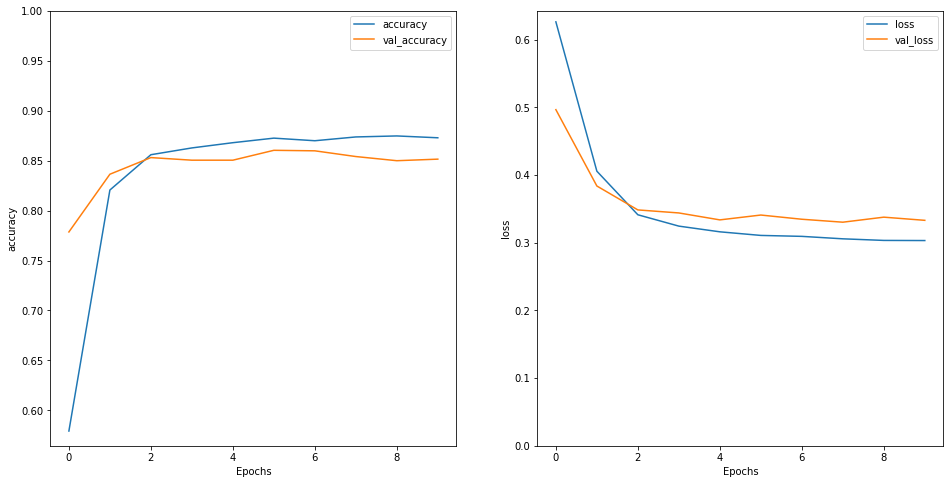

In [83]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [84]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[0.4689005]]


# **결과분석** 

---
# **Unidirectional**
Test loss: 0.3264

Test accuracy: 0.8508

Sample text Prediction : 0.6089729 

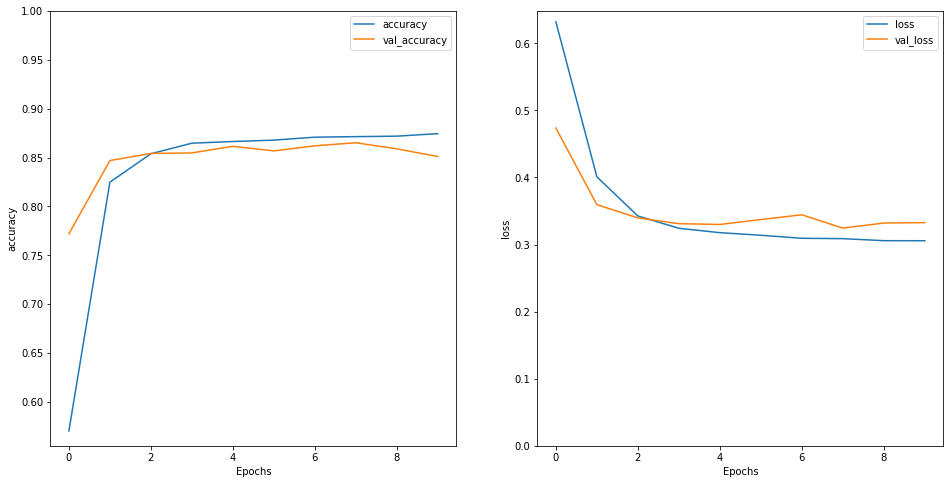

# **Bidirectional**

Test Loss: 0.32600051164627075

Test Accuracy: 0.862280011177063

Sample Text Prediction : 0.85939723

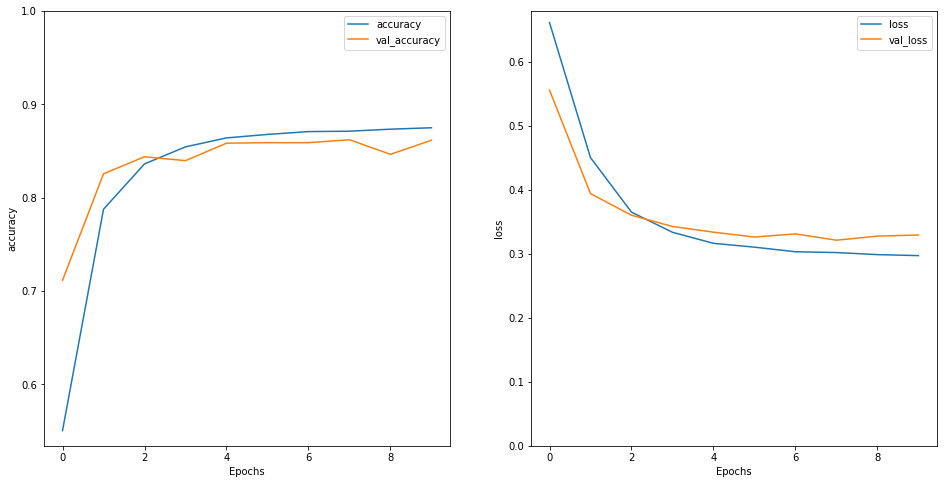